In [156]:
from skimage.io import imshow
from skimage.transform import resize
from skimage import exposure
from skimage import draw
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

class HOG:
  
    def calculate_magnitude_orientation(self,img):
        gradient_y = np.empty(img.shape, dtype=np.double)
        gradient_y[0, :] = 0
        gradient_y[-1, :] = 0
        gradient_y[1:-1, :] = img[2:, :] - img[:-2, :]
        gradient_x = np.empty(img.shape, dtype=np.double)
        gradient_x[:, 0] = 0
        gradient_x[:, -1] = 0
        gradient_x[:, 1:-1] = img[:, 2:] - img[:, :-2]
        magnitude = np.hypot(gradient_x,gradient_y)
        orientation = np.rad2deg(np.arctan2(gradient_y, gradient_x)) % 180
        if(img.ndim==3):
            mg = np.empty((magnitude.shape[0],magnitude.shape[1]))
            ag = np.empty((orientation.shape[0],orientation.shape[1]))
            for i in range(magnitude.shape[0]):
                for j in range(magnitude.shape[1]):
                    index = np.argmax(magnitude[i][j])
                    mg[i][j] = magnitude[i][j][index]
                    ag[i][j] = orientation[i][j][index]
            return mg,ag
            
        return magnitude,orientation
    
    def get_hist_cell(self,img,pixels_per_cell=(8,8),cells_per_block=(2,2),bins=9):
        
        #number of cells in x direction
        no_of_cells_x = img.shape[1]//pixels_per_cell[1]
        
        #number of cells in y direction
        no_of_cells_y = img.shape[0]//pixels_per_cell[0]
        
        angle_range = 180//bins
        
        # creating histogram matrix (shape : [no_of_cells_x][no_of_cells_y][bins])
        
        orientation_histogram = np.zeros((no_of_cells_y, no_of_cells_x, bins))
        
        magnitude,orientation = self.calculate_magnitude_orientation(img)
        
        for row in range(no_of_cells_y):
            for col in range(no_of_cells_x):
                for i in range(pixels_per_cell[0]):
                    for j in range(pixels_per_cell[1]):
                        angle = orientation[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]].astype(int)
                        mg = magnitude[i+row*pixels_per_cell[0]][j+col*pixels_per_cell[1]].astype(int)
                        if(angle%angle_range==0):
                            orientation_histogram[row][col][(angle//20)%9] += mg
                        else:
                            pa = (angle//angle_range)*angle_range
                            na = pa+angle_range
                            orientation_histogram[row][col][pa//angle_range] += ((na-angle)/angle_range)*angle
                            orientation_histogram[row][col][(na//angle_range)%9] += ((angle-pa)/angle_range)*angle
                        

        return orientation_histogram
    
    
    def visualize_hog(self,img,orientation_histogram,pixels_per_cell,cells_per_block,bins):
        s_row, s_col = img.shape[:2]
        c_row, c_col = 8,8
        b_row, b_col = 2,2
        
        n_cells_row = int(s_row // c_row)  # number of cells along row-axis
        n_cells_col = int(s_col // c_col)  # number of cells along col-axis
        orientations = bins
        ot = self.get_hist_cell(img)
        # now compute the histogram for each cell
        hog_image = None
        radius = min(c_row, c_col) // 2 - 1
        orientations_arr = np.arange(orientations)
        # set dr_arr, dc_arr to correspond to midpoints of orientation bins
        orientation_bin_midpoints = (
            np.pi * (orientations_arr + .5) / orientations)
        dr_arr = radius * np.sin(orientation_bin_midpoints)
        dc_arr = radius * np.cos(orientation_bin_midpoints)
        hog_image = np.zeros((s_row, s_col), dtype=float)
        for r in range(n_cells_row):
            for c in range(n_cells_col):
                for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                    centre = tuple([r * c_row + c_row // 2,
                                    c * c_col + c_col // 2])
                    rr, cc = draw.line(int(centre[0] - dc),
                                       int(centre[1] + dr),
                                       int(centre[0] + dc),
                                       int(centre[1] - dr))
                    hog_image[rr, cc] += orientation_histogram[r, c, o]
        imshow(hog_image,cmap="gray")
    
    
    def hog(self,image,pixels_per_cell=(8,8),cells_per_block=(2,2),bins=9,visualize=True):
        final_feature = []
        orientation_histogram = self.get_hist_cell(image,pixels_per_cell,cells_per_block,bins)
        ot = np.copy(orientation_histogram)
        
        if(image.shape[0]==pixels_per_cell[0]):
            return np.array(list(np.concatenate(orientation_histogram).flat))
        
        for i in range(orientation_histogram.shape[0]-1):
            for j in range(orientation_histogram.shape[1]-1):
                norm = np.sqrt(np.sum(np.square(orientation_histogram[i:(i+cells_per_block[0]),j:(j+cells_per_block[1])])))
                copy_hog=orientation_histogram[i:(i+cells_per_block[0]),j:(j+cells_per_block[0])]
                if(norm!=0):
                    copy_hog/=norm
                final_feature.append(copy_hog.reshape(bins*cells_per_block[0]*cells_per_block[1]))
        feature_vector = np.array(list(np.concatenate(final_feature).flat))
        if(visualize):
            self.visualize_hog(image,ot,pixels_per_cell,cells_per_block,bins)
        return feature_vector

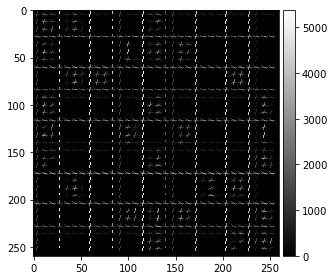

In [157]:
from skimage.io import imread, imshow
img = imread('sudoku-img-2.png')
hog = HOG()
array = hog.hog(img,visualize=True)

In [189]:
def phog(img,levels):
    phog_vector = np.array([])
    
    for level in range(levels):
        pixels_per_cell = (img.shape[0]//2**level,img.shape[1]//2**level)
        hog_object = HOG()
        level_hog_vector = hog_object.hog(img,pixels_per_cell,(1,1),bins=9,visualize=False)
        phog_vector = np.append(phog_vector,level_hog_vector)
    return phog_vector

In [190]:
a = phog(img,3)
a

sdfds 9
sdfds 9
sdfds 81


array([1.37960260e+06, 1.92018500e+04, 5.17396000e+04, 4.94434000e+04,
       4.58191500e+05, 4.11682050e+05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.15361422e-01, 1.34533617e-02, 3.80113693e-02,
       3.89738171e-02, 3.00344128e-01, 2.62225202e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.96348398e-01, 1.51113523e-02,
       3.98510215e-02, 4.85270316e-02, 3.31601306e-01, 2.87104153e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.13652564e-01,
       4.22738079e-03, 1.71386243e-02, 2.13831022e-02, 2.98219879e-01,
       2.74836416e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.34019622e-01, 2.14063141e-02, 4.23056129e-02, 3.78021619e-02,
       4.02730592e-01, 3.72212764e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.25181387e-01, 2.02609130e-02, 5.02919811e-02,
       5.19041606e-02, 2.83474563e-01, 2.40930993e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.25164990e-01, 1.40193593e-02,
      

2